In [267]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from datetime import timedelta
from time import time
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import statsmodels.api as sm

dataset = pd.read_csv('Out_60.csv')
dataset = dataset.drop(["Unnamed: 0", 'last_outcome_category', 'location'], axis=1)
mask = dataset['ward_name']!=dataset['ward_name']
dataset = dataset[~mask]


# Sarima

In [268]:
# # Sets the timeseries start and end date, creates the timeseries, 
# # gets the anomaly months, and averages those values
# # Also creates the first difference time series.

# data_start = date(2010, 12, 1)
# data_end = date(2022, 9, 1)


# sarima_timeseries = groups.count()['Longitude']
# sarima_timeseries = pd.Series(sarima_timeseries.values,index=[pd.Timestamp(x, freq='M') for x in sarima_timeseries.index])
# sarima_timeseries = sarima_timeseries[data_start:data_end]
# sarima_df = pd.DataFrame(sarima_timeseries).reset_index()

# remove_start = date(2019, 11, 1)
# remove_end = date(2020, 7, 1)

# def anomaly_avg(timestamp):
#     temp = sarima_df[sarima_df['index'].dt.month == timestamp.month]
#     temp = temp[temp['index'].dt.year != timestamp.year]
#     return int(temp[0].mean())

# corona_df = pd.DataFrame(sarima_timeseries[remove_start:remove_end]).reset_index()

# for x in corona_df['index']:
#     sarima_timeseries[x] = anomaly_avg(x)
    
# sarima_timeseries_diff = sarima_timeseries.diff()[1:]
# sarima_timeseries_diff = pd.Series(sarima_timeseries_diff.values,index=[pd.Timestamp(x) for x in sarima_timeseries_diff.index])

In [269]:
# # Prints and plots the ACF and PACF plots and the augmented dickey fuller tests

# plot_acf(sarima_timeseries_diff);
# adfull_time = adfuller(sarima_timeseries)
# print('P-value of the time series:', round(adfull_time[1], 3))
# adfull_time = adfuller(sarima_timeseries_diff)
# print('P-value of the first differenced time series:', round(adfull_time[1], 3))
# plot_pacf(sarima_timeseries_diff, method='ywm');

In [296]:
def prepare_timeseries(timeseries):
    
    data_start = date(2010, 12, 1)
    data_end = date(2022, 9, 1)
    timeseries = pd.Series(timeseries.values,index=[pd.Timestamp(x, freq='M') for x in timeseries.index])
    timeseries = timeseries[data_start:data_end]
    
    return timeseries

def training(timeseries):

    train_end = date(2022, 1, 1)
    test_end = date(2022, 9, 1)

    train_data = timeseries[:train_end]
    test_data = timeseries[train_end+timedelta(days=1):test_end]
    
    return train_data, test_data

def corona_troubles(timeseries):
    remove_start = date(2019, 11, 1)
    remove_end = date(2020, 7, 1)
    temp_df = pd.DataFrame(timeseries).reset_index()
    
    
    for x in timeseries[remove_start:remove_end].index:
        temp = temp_df[temp_df['index'].dt.month == x.month]
        temp = temp[temp['index'].dt.year != x.year]
        timeseries[x] = int(temp[0].mean())
        
    return timeseries

def create_model(train_data, my_order, my_seasonal_order):
#     my_order = (0,1,0)
#     my_seasonal_order = (2, 0, 1, 6)
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    
    start = time()
    model_fit = model.fit()
    end = time()
#     print("Model Fitting Time:", end - start)
    
    return model_fit



def pred_res(model_fit, test_data):
    
    predictions = model_fit.forecast(len(test_data))
    predictions = pd.Series(predictions, index=test_data.index)
    residuals = test_data - predictions
    
    return predictions, residuals

def plot_residuals(residuals):
    plt.figure(figsize=(10,4))
    plt.plot(residuals)
    plt.axhline(0, linestyle='--', color='k')
    plt.title('Residuals from SARIMA Model', fontsize=20)
    plt.ylabel("Error", fontsize=16);
    
def plot_predictions(timeseries, predictions):
    plt.figure(figsize=(10,4))

    start_date = timeseries.index[0]
    end_date = timeseries.index[-1]

    plt.plot(timeseries)
    plt.plot(predictions)

    plt.legend(('Data', 'Predictions'), fontsize=16)

    plt.title('Amount of crimes in Barnet', fontsize=20)
    plt.ylabel('Crimes', fontsize=16)
    for year in range(start_date.year+1,end_date.year+1):
        plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
        
def statistics(residuals, test_data):
#     print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))
#     print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))
    MAPE = round(np.mean(abs(residuals/test_data)),4)
    RMSE = np.sqrt(np.mean(residuals**2))
    return MAPE, RMSE
    
def rolling_pred_res(train_data, test_data, timeseries, my_order, my_seasonal_order):
#     my_order = (0,1,0)
#     my_seasonal_order = (2, 0, 1, 6)
    rolling_predictions = test_data.copy()
    for train_end in test_data.index:
        train_data = timeseries[:train_end-timedelta(days=1)]
        model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
        model_fit = model.fit()

        pred = model_fit.forecast()
        rolling_predictions[train_end] = pred

    rolling_residuals = test_data - rolling_predictions
    
    return rolling_predictions, rolling_residuals, model_fit

def plot_rolling_residuals(rolling_residuals):
    plt.figure(figsize=(10,4))
    plt.plot(rolling_residuals)
    plt.axhline(0, linestyle='--', color='k')
    plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
    plt.ylabel('Error', fontsize=16);
    

def plot_rolling_predictions(timeseries, rolling_predictions):
    plt.figure(figsize=(10,4))
    
    start_date = timeseries.index[0]
    end_date = timeseries.index[-1]

    plt.plot(timeseries)
    plt.plot(rolling_predictions)

    plt.legend(('Data', 'Predictions'), fontsize=16)

    plt.title('Rolling Forecast prediction Crimes in Barnet', fontsize=20)
    plt.ylabel('Crimes', fontsize=16)
    for year in range(start_date.year+1,end_date.year+1):
        plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
        
        
def rolling_statistics(rolling_residuals, test_data):
#     print('Rolling Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))
#     print('Rolling Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))
    RMAPE = round(np.mean(abs(rolling_residuals/test_data)),4)
    RRMSE = np.sqrt(np.mean(rolling_residuals**2))
    
    return RMAPE, RRMSE

In [297]:
def run_functions(temp_timeseries):
    temp_timeseries = prepare_timeseries(temp_timeseries)
    temp_timeseries = corona_troubles(temp_timeseries)
    temp_train, temp_test = training(temp_timeseries)
    
#     temp_model_fit = create_model(temp_train, my_order, my_seasonal_order)
#     temp_predictions, temp_residuals = pred_res(temp_model_fit, temp_test)
    # plot_residuals(temp_residuals)
    # plot_predictions(temp_timeseries, temp_predictions)
#     temp_mape, temp_rmse = statistics(temp_residuals, temp_test)

    temp_rolling_predictions, temp_rolling_residuals, model_fit = rolling_pred_res(temp_train, temp_test, temp_timeseries, my_order, my_seasonal_order)
#     plot_rolling_residuals(temp_rolling_residuals)
#     plot_rolling_predictions(temp_timeseries, temp_rolling_predictions)
    temp_rmape, temp_rrmse = rolling_statistics(temp_rolling_residuals, temp_test)
    
    return temp_rmape, temp_rrmse, model_fit

In [223]:
# # Part that runs each individual ward with the same parameters as the big one
# rmse_lst = []
# mape_lst = []
# for x in result['WD22NM'].unique():
#     df_temp = result[result['WD22NM'] == x]
#     temp_timeseries = df_temp.groupby("Month").count()['Latitude']
#     x, y = run_functions(temp_timeseries)
#     mape_lst.append(x)
#     rmse_lst.append(y)

In [224]:
# Average mape with the same order and seasonal order in the model as the whole dataset
# np.mean(copy_mape_lst)
# 0.54426

In [272]:
orders = []
for x in [0,1]:
    for y in [0,1]:
        for z in [0,1,2]:
            orders.append((x,y,z))
            
seasonal_orders = []
for x in [1,2]:
    for y in [0]:
        for z in [0,1]:
            for s in [6, 12]:
                seasonal_orders.append((x,y,z,s))

In [235]:
best_order_lst = []
i=0
for x in tqdm(dataset['ward_name'].unique()):
    i+=1
    start= time()
    looking_lst = []
    for y in orders:
        for z in seasonal_orders:
            try:
                my_order = y
                my_seasonal_order = z
                df_temp = dataset[dataset['ward_name'] == x]
                temp_timeseries = df_temp.groupby("month").count()['latitude']
                new_temp_mape, new_temp_rmse = run_functions(temp_timeseries)
                looking_lst.append([(x,y,z), new_temp_mape, new_temp_rmse])
            except:
                print((x,y,z), 'Does not work')
    
    lowest = 1
    for val in looking_lst:
        if val[1] < lowest:
            lowest = val[1]
            best = val
    best_order_lst.append(best)
    end = time()
    print('{} took {} seconds.'.format(x, end-start))
    print('Best:', best)
    

  4%|███▎                                                                            | 1/24 [02:41<1:02:00, 161.75s/it]

High Barnet took 161.75029730796814 seconds.
Best: [('High Barnet', (0, 0, 0), (1, 0, 0, 12)), 0.1859, 1.541103500742244]


  8%|██████▊                                                                           | 2/24 [04:54<53:08, 144.95s/it]

Underhill took 133.19078636169434 seconds.
Best: [('Underhill', (1, 0, 1), (2, 0, 1, 6)), 0.425, 1.8027756377319946]


 12%|██████████▎                                                                       | 3/24 [07:52<55:55, 159.79s/it]

East Barnet took 177.45378947257996 seconds.
Best: [('East Barnet', (0, 0, 1), (1, 0, 0, 12)), 0.3512, 1.7320508075688772]


 17%|█████████████▋                                                                    | 4/24 [10:13<50:52, 152.61s/it]

Barnet Vale took 141.5876989364624 seconds.
Best: [('Barnet Vale', (0, 0, 1), (2, 0, 0, 6)), 0.2572, 2.3717082451262845]


 21%|█████████████████                                                                 | 5/24 [12:45<48:12, 152.23s/it]

Edgwarebury took 151.5725016593933 seconds.
Best: [('Edgwarebury', (0, 1, 2), (1, 0, 0, 6)), 0.2646, 1.1726039399558574]


 25%|████████████████████▌                                                             | 6/24 [15:51<49:05, 163.63s/it]

Totteridge & Woodside took 185.75988364219666 seconds.
Best: [('Totteridge & Woodside', (0, 0, 0), (2, 0, 0, 12)), 0.2679, 3.0618621784789726]
('Whetstone', (1, 1, 2), (2, 0, 1, 6)) Does not work


 29%|███████████████████████▉                                                          | 7/24 [19:27<51:11, 180.66s/it]

Whetstone took 215.72865056991577 seconds.
Best: [('Whetstone', (0, 1, 1), (1, 0, 0, 6)), 0.1949, 2.091650066335189]


 33%|███████████████████████████▎                                                      | 8/24 [22:12<46:53, 175.83s/it]

Brunswick Park took 165.47792410850525 seconds.
Best: [('Brunswick Park', (1, 1, 0), (1, 0, 1, 12)), 0.3772, 2.622022120425379]


 38%|██████████████████████████████▊                                                   | 9/24 [25:13<44:21, 177.42s/it]

Woodhouse took 180.91035914421082 seconds.
Best: [('Woodhouse', (0, 0, 0), (2, 0, 0, 6)), 0.3013, 2.1213203435596424]


 42%|█████████████████████████████████▊                                               | 10/24 [27:51<39:58, 171.34s/it]

Edgware took 157.72220873832703 seconds.
Best: [('Edgware', (0, 0, 1), (2, 0, 1, 12)), 0.1818, 2.3979157616563596]


 46%|█████████████████████████████████████▏                                           | 11/24 [31:22<39:47, 183.63s/it]

Friern Barnet took 211.50728583335876 seconds.
Best: [('Friern Barnet', (0, 0, 0), (2, 0, 1, 6)), 0.0734, 1.5]
('Mill Hill', (0, 1, 2), (1, 0, 1, 12)) Does not work


 50%|████████████████████████████████████████▌                                        | 12/24 [35:16<39:45, 198.79s/it]

Mill Hill took 233.44328999519348 seconds.
Best: [('Mill Hill', (0, 0, 1), (1, 0, 0, 12)), 0.2139, 2.7613402542968153]
('Burnt Oak', (1, 0, 0), (1, 0, 1, 6)) Does not work


 54%|███████████████████████████████████████████▉                                     | 13/24 [38:32<36:19, 198.18s/it]

Burnt Oak took 196.77164793014526 seconds.
Best: [('Burnt Oak', (1, 0, 1), (1, 0, 0, 6)), 0.4433, 5.522680508593631]
('West Finchley', (1, 0, 0), (1, 0, 1, 6)) Does not work
('West Finchley', (1, 0, 0), (2, 0, 1, 6)) Does not work


 58%|███████████████████████████████████████████████▎                                 | 14/24 [41:51<33:03, 198.33s/it]

West Finchley took 198.66871619224548 seconds.
Best: [('West Finchley', (0, 1, 1), (1, 0, 1, 12)), 0.2999, 2.7613402542968153]
('Finchley Church End', (1, 0, 0), (1, 0, 1, 12)) Does not work


 62%|██████████████████████████████████████████████████▋                              | 15/24 [45:01<29:22, 195.84s/it]

Finchley Church End took 190.07277631759644 seconds.
Best: [('Finchley Church End', (0, 0, 2), (1, 0, 0, 6)), 0.1267, 1.5811388300841898]
('Colindale North', (1, 0, 2), (2, 0, 1, 12)) Does not work


 67%|██████████████████████████████████████████████████████                           | 16/24 [48:49<27:23, 205.47s/it]

Colindale North took 227.82957005500793 seconds.
Best: [('Colindale North', (0, 0, 0), (2, 0, 0, 6)), 0.2292, 1.5811388300841898]
('East Finchley', (1, 0, 0), (2, 0, 1, 6)) Does not work


 71%|█████████████████████████████████████████████████████████▍                       | 17/24 [51:44<22:54, 196.31s/it]

East Finchley took 175.00836634635925 seconds.
Best: [('East Finchley', (0, 0, 0), (2, 0, 1, 12)), 0.3156, 3.0618621784789726]


 75%|████████████████████████████████████████████████████████████▊                    | 18/24 [54:47<19:13, 192.33s/it]

Hendon took 183.0688135623932 seconds.
Best: [('Hendon', (1, 0, 0), (1, 0, 0, 6)), 0.5806, 9.334077351297235]


 79%|████████████████████████████████████████████████████████████████▏                | 19/24 [57:37<15:27, 185.55s/it]

Garden Suburb took 169.75254845619202 seconds.
Best: [('Garden Suburb', (1, 1, 0), (1, 0, 1, 6)), 0.2307, 1.8371173070873836]


 83%|█████████████████████████████████████████████████████████████████▊             | 20/24 [1:00:11<11:45, 176.26s/it]

West Hendon took 154.6012670993805 seconds.
Best: [('West Hendon', (1, 1, 1), (1, 0, 0, 6)), 0.1589, 2.091650066335189]


 88%|█████████████████████████████████████████████████████████████████████▏         | 21/24 [1:03:11<08:52, 177.34s/it]

Golders Green took 179.87894487380981 seconds.
Best: [('Golders Green', (0, 0, 0), (1, 0, 0, 6)), 0.29, 3.7416573867739413]


 92%|████████████████████████████████████████████████████████████████████████▍      | 22/24 [1:06:29<06:06, 183.43s/it]

Childs Hill took 197.63284730911255 seconds.
Best: [('Childs Hill', (0, 1, 2), (2, 0, 0, 6)), 0.2775, 5.431390245600108]


 96%|███████████████████████████████████████████████████████████████████████████▋   | 23/24 [1:08:58<02:53, 173.27s/it]

Cricklewood took 149.55541062355042 seconds.
Best: [('Cricklewood', (0, 0, 1), (1, 0, 0, 6)), 0.2417, 3.7080992435478315]
('Colindale South', (1, 0, 1), (1, 0, 1, 12)) Does not work
('Colindale South', (1, 0, 1), (2, 0, 1, 12)) Does not work
('Colindale South', (1, 0, 2), (2, 0, 1, 6)) Does not work
('Colindale South', (1, 1, 2), (2, 0, 1, 6)) Does not work


100%|███████████████████████████████████████████████████████████████████████████████| 24/24 [1:10:40<00:00, 176.70s/it]

Colindale South took 101.88161993026733 seconds.
Best: [('Colindale South', (0, 1, 1), (1, 0, 0, 6)), 0.0, 0.0]


# DO NOT RUN THIS ONE BUT THE LIST HAS ALL THE PARAMETERS AND MAPE AND RMSE OF THE WARDS

In [262]:
best_order_lst

[[('High Barnet', (0, 0, 0), (1, 0, 0, 12)), 0.1859, 1.541103500742244],
 [('Underhill', (1, 0, 1), (2, 0, 1, 6)), 0.425, 1.8027756377319946],
 [('East Barnet', (0, 0, 1), (1, 0, 0, 12)), 0.3512, 1.7320508075688772],
 [('Barnet Vale', (0, 0, 1), (2, 0, 0, 6)), 0.2572, 2.3717082451262845],
 [('Edgwarebury', (0, 1, 2), (1, 0, 0, 6)), 0.2646, 1.1726039399558574],
 [('Totteridge & Woodside', (0, 0, 0), (2, 0, 0, 12)),
  0.2679,
  3.0618621784789726],
 [('Whetstone', (0, 1, 1), (1, 0, 0, 6)), 0.1949, 2.091650066335189],
 [('Brunswick Park', (1, 1, 0), (1, 0, 1, 12)), 0.3772, 2.622022120425379],
 [('Woodhouse', (0, 0, 0), (2, 0, 0, 6)), 0.3013, 2.1213203435596424],
 [('Edgware', (0, 0, 1), (2, 0, 1, 12)), 0.1818, 2.3979157616563596],
 [('Friern Barnet', (0, 0, 0), (2, 0, 1, 6)), 0.0734, 1.5],
 [('Mill Hill', (0, 0, 1), (1, 0, 0, 12)), 0.2139, 2.7613402542968153],
 [('Burnt Oak', (1, 0, 1), (1, 0, 0, 6)), 0.4433, 5.522680508593631],
 [('West Finchley', (0, 1, 1), (1, 0, 1, 12)), 0.2999, 2.761

In [326]:
ward = 'Underhill'
my_order = (0,0,0)
my_seasonal_order = (2,0,0,6)
df_temp = dataset[dataset['ward_name'] == ward]
temp_timeseries = df_temp.groupby("month").count()['latitude']
x, y, new_model_fit = run_functions(temp_timeseries)
[x for x in new_model_fit.forecast(8)][7]
# new_model_fit.forecast(8)

2.6375607862021706

# THIS ONE CAN BE USED TO FORECAST

In [318]:
dct = {}
for x in best_order_lst:
    ward = x[0][0]
    my_order = x[0][1]
    my_seasonal_order = x[0][2]
    df_temp = dataset[dataset['ward_name'] == ward]
    temp_timeseries = df_temp.groupby("month").count()['latitude']
    x, y, new_model_fit = run_functions(temp_timeseries)
    dct[ward] =  round([x for x in new_model_fit.forecast(8)][7])
    

In [319]:
dct

{'High Barnet': 6,
 'Underhill': 3,
 'East Barnet': 2,
 'Barnet Vale': 5,
 'Edgwarebury': 5,
 'Totteridge & Woodside': 5,
 'Whetstone': 6,
 'Brunswick Park': 6,
 'Woodhouse': 5,
 'Edgware': 8,
 'Friern Barnet': 7,
 'Mill Hill': 8,
 'Burnt Oak': 10,
 'West Finchley': 11,
 'Finchley Church End': 6,
 'Colindale North': 3,
 'East Finchley': 9,
 'Hendon': 2,
 'Garden Suburb': 5,
 'West Hendon': 9,
 'Golders Green': 6,
 'Childs Hill': 17,
 'Cricklewood': 3,
 'Colindale South': 2}

In [ ]:
worse = ['Totteridge & Woodside', 'Brunswick Park', 'West Finchley', 'East Finchley', 'Hendon', 'West Hendon']

In [238]:
difference = []

for x in best_order_lst:
    for y in copy_best_order_lst:
        if x[0][0] == y[0][0]:
            difference.append(y[1]-x[1])

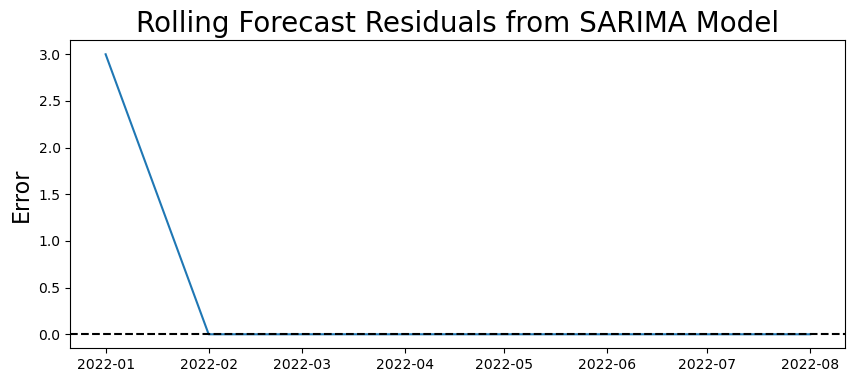

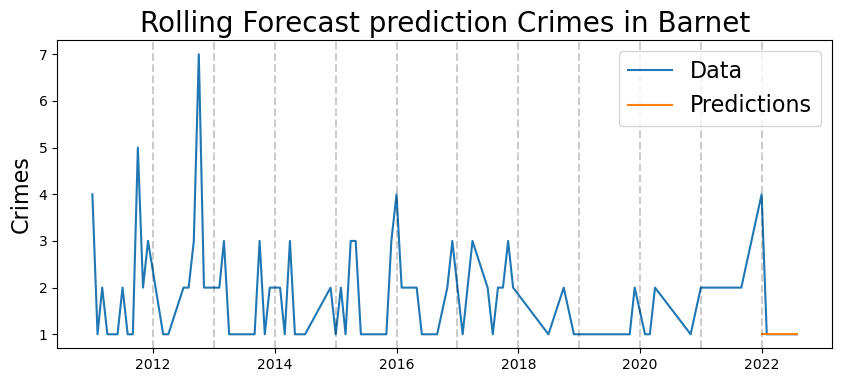

In [257]:
temp_df = dataset[dataset['ward_name'] == 'Colindale South']
temp_timeseries = df_temp.groupby("month").count()['latitude']
my_order = (0, 1, 1)
my_seasonal_order = (1, 0, 0, 6)
new_temp_mape, new_temp_rmse = run_functions(temp_timeseries)

In [258]:
new_temp_mape, new_temp_rmse

(0.15, 1.3416407864998738)

In [251]:
copy_best_order_lst

[[('West Hendon', (1, 0, 2), (1, 0, 0, 6)), 0.1507, 2.3717082451262845],
 [('East Finchley', (1, 0, 2), (2, 0, 1, 12)), 0.3128, 3.517811819867572],
 [('Finchley Church End', (0, 0, 1), (1, 0, 0, 6)),
  0.1286,
  1.8708286933869707],
 [('West Finchley', (1, 0, 1), (2, 0, 1, 6)), 0.2415, 2.4748737341529163],
 [('Hendon', (1, 0, 0), (1, 0, 0, 6)), 0.5732, 9.17877987534291],
 [('Burnt Oak', (1, 0, 1), (1, 0, 0, 6)), 0.4433, 5.522680508593631],
 [('Woodhouse', (0, 0, 1), (2, 0, 0, 6)), 0.314, 2.0],
 [('Friern Barnet', (1, 1, 2), (1, 0, 0, 12)), 0.0751, 1.5],
 [('Colindale North', (0, 0, 0), (2, 0, 0, 6)), 0.1979, 1.541103500742244],
 [('Mill Hill', (0, 0, 1), (1, 0, 0, 12)), 0.2139, 2.7613402542968153],
 [('Cricklewood', (0, 0, 1), (1, 0, 0, 6)), 0.251, 3.605551275463989],
 [('Childs Hill', (0, 1, 1), (2, 0, 0, 6)), 0.2834, 5.208166663999915],
 [('Golders Green', (0, 0, 0), (1, 0, 0, 6)), 0.29, 3.7416573867739413],
 [('Garden Suburb', (1, 1, 0), (1, 0, 1, 6)), 0.2445, 2.0615528128088303],
 

In [ ]:
(0, 1, 1), (1, 0, 0, 6))

In [236]:
best_order_lst

[[('High Barnet', (0, 0, 0), (1, 0, 0, 12)), 0.1859, 1.541103500742244],
 [('Underhill', (1, 0, 1), (2, 0, 1, 6)), 0.425, 1.8027756377319946],
 [('East Barnet', (0, 0, 1), (1, 0, 0, 12)), 0.3512, 1.7320508075688772],
 [('Barnet Vale', (0, 0, 1), (2, 0, 0, 6)), 0.2572, 2.3717082451262845],
 [('Edgwarebury', (0, 1, 2), (1, 0, 0, 6)), 0.2646, 1.1726039399558574],
 [('Totteridge & Woodside', (0, 0, 0), (2, 0, 0, 12)),
  0.2679,
  3.0618621784789726],
 [('Whetstone', (0, 1, 1), (1, 0, 0, 6)), 0.1949, 2.091650066335189],
 [('Brunswick Park', (1, 1, 0), (1, 0, 1, 12)), 0.3772, 2.622022120425379],
 [('Woodhouse', (0, 0, 0), (2, 0, 0, 6)), 0.3013, 2.1213203435596424],
 [('Edgware', (0, 0, 1), (2, 0, 1, 12)), 0.1818, 2.3979157616563596],
 [('Friern Barnet', (0, 0, 0), (2, 0, 1, 6)), 0.0734, 1.5],
 [('Mill Hill', (0, 0, 1), (1, 0, 0, 12)), 0.2139, 2.7613402542968153],
 [('Burnt Oak', (1, 0, 1), (1, 0, 0, 6)), 0.4433, 5.522680508593631],
 [('West Finchley', (0, 1, 1), (1, 0, 1, 12)), 0.2999, 2.761

In [19]:
mape_lst = []
for x in best_order_lst:
    mape_lst.append(x[1])

In [20]:
copy_best_order_lst = best_order_lst.copy()

In [23]:
# Average mape with the 'optimal' order for each of the wards (but wrong so only the last set of parameters one lmao)
#np.mean(mape_lst)  #(but wrong so only the last set of parameters one lmao)
# 0.4526

np.mean(mape_lst)
# 0.2696

0.2696043478260869

In [24]:
needs_work = []
for x in best_order_lst:
    if x[1] > 0.3:
        needs_work.append(x)

In [25]:
needs_work

[[('East Finchley', (1, 0, 2), (2, 0, 1, 12)), 0.3128, 3.517811819867572],
 [('Hendon', (1, 0, 0), (1, 0, 0, 6)), 0.5732, 9.17877987534291],
 [('Burnt Oak', (1, 0, 1), (1, 0, 0, 6)), 0.4433, 5.522680508593631],
 [('Woodhouse', (0, 0, 1), (2, 0, 0, 6)), 0.314, 2.0],
 [('Brunswick Park', (1, 1, 1), (1, 0, 1, 12)), 0.3469, 2.1505813167606567],
 [('East Barnet', (0, 0, 1), (1, 0, 0, 12)), 0.372, 1.8371173070873836],
 [('Underhill', (1, 0, 1), (2, 0, 1, 6)), 0.425, 1.8027756377319946]]

In [86]:
def get_timeseries(ward):
    df_temp = result[result['WD22NM'] == ward]
    temp_timeseries = df_temp.groupby("Month").count()['Latitude']
    temp_timeseries = prepare_timeseries(temp_timeseries)
    temp_timeseries = corona_troubles(temp_timeseries)
    
    return temp_timeseries

In [87]:
def run_arima_functions(ward, y):
    temp_timeseries = get_timeseries(ward)
    temp_train, temp_test = training(temp_timeseries)
    temp_preds, temp_res = rolling_pred_res_arima(temp_train, temp_test, temp_timeseries, y)
    temp_rmape, temp_rrse = rolling_statistics(temp_res, temp_test)

    return temp_rmape, temp_rrse

In [88]:
def rolling_pred_res_arima(train_data, test_data, timeseries, my_order):
#     my_order = (0,1,0)
    rolling_predictions = test_data.copy()
    for train_end in test_data.index:
        train_data = timeseries[:train_end-timedelta(days=1)]
        model = sm.tsa.arima.ARIMA(train_data, order=my_order)
        model_fit = model.fit()

        pred = model_fit.forecast()
        rolling_predictions[train_end] = pred

    rolling_residuals = test_data - rolling_predictions
    
    return rolling_predictions, rolling_residuals

In [91]:
orders = []
for x in [0,1,2]:
    for y in [0,1,2]:
        for z in [0,1,2]:
            orders.append((x,y,z))

In [92]:
needs_work_new_best = []
for x in needs_work:
    looking_lst = []
    start = time()
    for y in orders:
        temp_rmape, temp_rrse = run_arima_functions(x[0][0], y)
        looking_lst.append([(x[0][0],y), new_temp_mape, new_temp_rmse])
        
    lowest = 1
    for val in looking_lst:
        if val[1] < lowest:
            lowest = val[1]
            best = val
    needs_work_new_best.append(best)
    end = time()
    print('{} took {} seconds.'.format(x, end-start))
    print('Best:', best)
        
    

[('East Finchley', (1, 0, 2), (2, 0, 1, 12)), 0.3128, 3.517811819867572] took 18.655919075012207 seconds.
Best: [('East Finchley', (0, 0, 0)), 0.6187, 3.142451272494134]


KeyboardInterrupt: 

In [264]:
len(best_order_lst)

24

In [266]:
next_month = 
for x in best_order_lst:
    print(x[0][0])

High Barnet
Underhill
East Barnet
Barnet Vale
Edgwarebury
Totteridge & Woodside
Whetstone
Brunswick Park
Woodhouse
Edgware
Friern Barnet
Mill Hill
Burnt Oak
West Finchley
Finchley Church End
Colindale North
East Finchley
Hendon
Garden Suburb
West Hendon
Golders Green
Childs Hill
Cricklewood
Colindale South
